#### Libraries

In [ ]:
import pandas as pd
import numpy as np
import backtesting_base_mostoro as back
from datetime import time
from datetime import time, timedelta


In [ ]:

#Parameters to get data from backtesting base class
year = 2025
symbol = 'MES'
# start  = '2023-10-15' # it could be useful to fiter the data
# end    = '2023-10-27' # it could be useful to fiter the data
amount = 5000
bar_time = '1min'
stop_loss = 4
target = 8
#Calling backtesting base class to get some variables
backtesting_base = back.Backtesting(symbol, amount, bar_time, stop_loss, target) # calling backtesting base
data_intraday = backtesting_base.data


In [ ]:
data_intraday

### Getting Footprint

In [1]:
import pandas as pd 
ticks = pd.read_csv(r'/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/Data/archive/Initiative (Volume Profile)/Drafts/MES_02_2025.csv')
ticks

,Date,Last,Bid_Volume,Ask_Volume,Volume
0,2025-02-02 18:00:00,6008.00,0,2,2
1,2025-02-02 18:00:00,5990.00,0,1,1
2,2025-02-02 18:00:00,5990.00,0,1,1
3,2025-02-02 18:00:00,5990.00,0,1,1
4,2025-02-02 18:00:00,5990.00,0,1,1
...,...,...,...,...,...
11701157,2025-02-28 16:59:58,5957.50,0,1,1
11701158,2025-02-28 16:59:58,5957.50,0,1,1
11701159,2025-02-28 16:59:58,5957.75,1,0,1
11701160,2025-02-28 16:59:58,5957.50,0,4,4


/var/folders/16/sd6hb1h14pzcbdd626mkn93m0000gn/T/ipykernel_3340/3809920821.py:359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


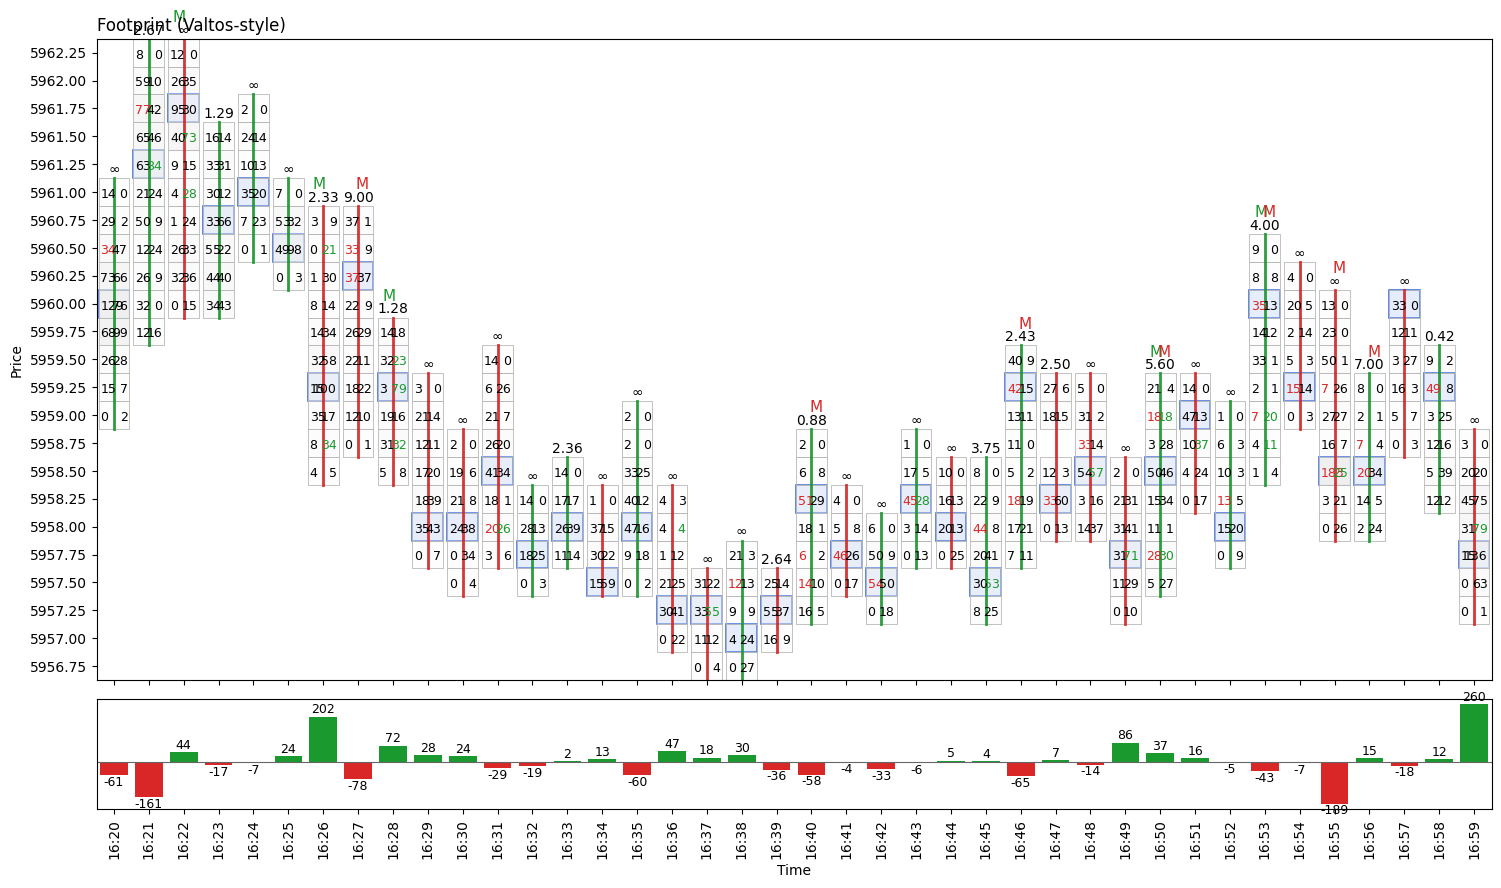

In [3]:
# ===============================================
# Valtos-style Footprint — SINGLE CELL FROM `ticks`
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

# -------------------------
# Config
# -------------------------
BAR_SIZE        = '1min'   # change to your bar size (e.g., '30s', '2min')
TICK_SIZE       = 0.25     # instrument tick size
IMB_RATIO       = 4.0      # diagonal imbalance ratio
REQUIRE_CP_GT0  = True     # require counterpart > 0
STACK_MIN       = 3        # consecutive levels for "S"
MULTI_IMB_N     = 2        # total imbalances for "M"
N_BARS_TO_PLOT  = 40
FIGSIZE         = (18, 10)
FONT_SIZE       = 9
BAR_GAP         = 0.12
BARLINE_WIDTH   = 2.0
VOL_ALPHA_FLOOR = 0.08

# -------------------------
# Helper: OHLC from ticks
# -------------------------
def build_ohlc_from_ticks(ticks: pd.DataFrame, bar=BAR_SIZE) -> pd.DataFrame:
    t = ticks.copy()
    if not np.issubdtype(t['Date'].dtype, np.datetime64):
        t['Date'] = pd.to_datetime(t['Date'])
    t['BarTime'] = t['Date'].dt.floor(bar)

    t_sorted = t.sort_values('Date')
    open_  = t_sorted.groupby('BarTime')['Last'].first()
    close_ = t_sorted.groupby('BarTime')['Last'].last()
    high_  = t.groupby('BarTime')['Last'].max()
    low_   = t.groupby('BarTime')['Last'].min()

    ohlc = pd.DataFrame({'Open': open_, 'High': high_, 'Low': low_, 'Close': close_}).reset_index()
    return ohlc

# -------------------------
# Build `bars` and `foot` from ticks
# -------------------------
def build_bars_and_foot_from_ticks(ticks: pd.DataFrame,
                                   tick_size=TICK_SIZE,
                                   bar=BAR_SIZE):
    t = ticks.copy()
    if not np.issubdtype(t['Date'].dtype, np.datetime64):
        t['Date'] = pd.to_datetime(t['Date'])
    t['BarTime'] = t['Date'].dt.floor(bar)

    # Normalize trade price to the tick grid (if already aligned, this keeps it)
    t['Price'] = (np.round(t['Last'] / tick_size) * tick_size).astype(float)

    # --- foot (per BarTime x Price) ---
    grp = t.groupby(['BarTime','Price'], as_index=False).agg(
        Bid_Volume=('Bid_Volume','sum'),
        Ask_Volume=('Ask_Volume','sum'),
        Total=('Volume','sum'),
    )
    foot = grp.sort_values(['BarTime','Price']).reset_index(drop=True)

    # --- bars (per BarTime) ---
    bb = t.groupby('BarTime').agg(
        PriceMin=('Price','min'),
        PriceMax=('Price','max'),
        BidSum=('Bid_Volume','sum'),
        AskSum=('Ask_Volume','sum'),
        Vol=('Volume','sum'),
    ).reset_index()
    bb['BarDelta'] = (bb['AskSum'] - bb['BidSum']).astype(int)

    # POC (price of max Total within each bar)
    poc = foot.groupby(['BarTime','Price'])['Total'].sum().reset_index()
    poc = poc.sort_values(['BarTime','Total']).groupby('BarTime').tail(1)
    bb = bb.merge(poc[['BarTime','Price']].rename(columns={'Price':'POC_Price'}), on='BarTime', how='left')

    # Add OHLC (from raw ticks) for proper bull/bear classification
    ohlc = build_ohlc_from_ticks(t, bar=bar)
    bars = bb.merge(ohlc, on='BarTime', how='left').sort_values('BarTime').reset_index(drop=True)

    return bars, foot, ohlc

# -------------------------
# Valtos ratio features
# -------------------------
def _two_levels_side(vals_by_price: dict, t, penultimate_price, last_price):
    pen = float(vals_by_price.get((str(t), penultimate_price), 0.0))
    last = float(vals_by_price.get((str(t), last_price), 0.0))
    return pen, last

def build_valtos_features(foot: pd.DataFrame,
                          bars: pd.DataFrame,
                          tick_size=TICK_SIZE) -> pd.DataFrame:
    f = foot[['BarTime','Price','Bid_Volume','Ask_Volume']].copy()
    key = list(zip(f['BarTime'].astype(str), f['Price']))
    bid_at = dict(zip(key, f['Bid_Volume']))
    ask_at = dict(zip(key, f['Ask_Volume']))

    rows = []
    for _, row in bars.iterrows():
        t   = row['BarTime']
        low = row['PriceMin']
        high= row['PriceMax']
        op  = row['Open']
        cl  = row['Close']

        bullish = (pd.notna(op) and pd.notna(cl) and cl > op)
        bearish = (pd.notna(op) and pd.notna(cl) and cl < op)

        if bullish:
            pen, last = _two_levels_side(bid_at, t, round(low + tick_size, 10), low)
        elif bearish:
            pen, last = _two_levels_side(ask_at, t, round(high - tick_size, 10), high)
        else:
            pen, last = (np.nan, np.nan)

        # ratio metrics (penultimate / last) — ∞ if last==0 and penultimate>0
        ratio_last = last
        ratio_diff = np.nan if (np.isnan(pen) or np.isnan(last)) else abs(pen - last)
        if np.isnan(pen) or np.isnan(last):
            ratio_frac = np.nan
        elif last == 0:
            ratio_frac = np.inf if pen > 0 else np.nan
        else:
            ratio_frac = pen / last

        rows.append({
            'BarTime'    : t,
            'Open'       : op,
            'Close'      : cl,
            'Delta'      : int(row.get('BarDelta', 0)),
            'POC'        : row.get('POC_Price', np.nan),
            'Ratio_last' : ratio_last,
            'Ratio_diff' : ratio_diff,
            'Ratio_frac' : ratio_frac,
        })
    return pd.DataFrame(rows)

# -------------------------
# Imbalances by side from `foot`
# -------------------------
def _max_run(bool_series: pd.Series) -> int:
    run = m = 0
    for v in bool_series.astype(bool).tolist():
        run = run + 1 if v else 0
        m = max(m, run)
    return m

def compute_bar_imbalances_from_foot(foot: pd.DataFrame,
                                     imb_ratio: float = IMB_RATIO,
                                     require_counterpart_gt0: bool = REQUIRE_CP_GT0) -> pd.DataFrame:
    f = foot[['BarTime','Price','Bid_Volume','Ask_Volume']].copy()
    f = f.sort_values(['BarTime','Price']).reset_index(drop=True)

    # diagonal counterparts
    f['Bid_dn'] = f.groupby('BarTime')['Bid_Volume'].shift(1)   # Bid@(P-1) vs Ask@P
    f['Ask_up'] = f.groupby('BarTime')['Ask_Volume'].shift(-1)  # Ask@(P+1) vs Bid@P

    if require_counterpart_gt0:
        f['LongImb']  = (f['Ask_Volume'] >= imb_ratio * f['Bid_dn']) & (f['Bid_dn'] > 0)
        f['ShortImb'] = (f['Bid_Volume'] >= imb_ratio * f['Ask_up']) & (f['Ask_up'] > 0)
    else:
        f['LongImb']  = (f['Ask_Volume']  >= imb_ratio * f['Bid_dn'].fillna(0))
        f['ShortImb'] = (f['Bid_Volume'] >= imb_ratio * f['Ask_up'].fillna(0))

    counts = f.groupby('BarTime').agg(
        LongCount=('LongImb','sum'),
        ShortCount=('ShortImb','sum'),
    )
    runs_long  = f.groupby('BarTime')['LongImb'].apply(_max_run).rename('LongMaxRun')
    runs_short = f.groupby('BarTime')['ShortImb'].apply(_max_run).rename('ShortMaxRun')

    out = counts.join(runs_long).join(runs_short).reset_index()
    for c in ['LongCount','ShortCount','LongMaxRun','ShortMaxRun']:
        out[c] = out[c].fillna(0).astype(int)
    return out

# -------------------------
# Renderer
# -------------------------
def render_valtos_footprint(
    foot: pd.DataFrame,
    bars: pd.DataFrame,
    bt: pd.DataFrame,
    *,
    n_bars: int = N_BARS_TO_PLOT,
    tick_size: float = TICK_SIZE,
    imbalance_ratio: float = IMB_RATIO,
    require_counterpart_gt0: bool = REQUIRE_CP_GT0,
    stack_min: int = STACK_MIN,
    multi_imb_n: int = MULTI_IMB_N,
    font_size: int = FONT_SIZE,
    figsize: tuple = FIGSIZE,
    vol_alpha_floor: float = VOL_ALPHA_FLOOR,
    bar_gap: float = BAR_GAP,
    barline_width: float = BARLINE_WIDTH,
    show_delta_panel: bool = True
):
    # select window
    bars_ = bars.sort_values("BarTime").tail(n_bars).reset_index(drop=True)
    times = list(pd.to_datetime(bars_["BarTime"]))
    f = foot[foot["BarTime"].isin(times)].copy().sort_values(["BarTime","Price"]).reset_index(drop=True)

    bt_ = bt[bt["BarTime"].isin(times)].sort_values("BarTime").reset_index(drop=True)
    bt_map = bt_.set_index('BarTime')

    # ladder
    pmin, pmax = f["Price"].min(), f["Price"].max()
    ladder = np.arange(pmin, pmax + tick_size, tick_size)
    price_to_row = {p:i for i,p in enumerate(ladder)}

    # POC
    poc_by_time = (
        f.groupby(["BarTime","Price"])["Total"].sum()
         .reset_index()
         .sort_values(["BarTime","Total"])
         .groupby("BarTime").tail(1)
         .set_index("BarTime")["Price"]
    )

    # lookups for digits
    key = list(zip(f["BarTime"].astype(str), f["Price"]))
    d_bid = dict(zip(key, f["Bid_Volume"]))
    d_ask = dict(zip(key, f["Ask_Volume"]))
    d_tot = dict(zip(key, f["Total"]))

    # diagonal counterparts
    f = f.sort_values(["BarTime","Price"]).reset_index(drop=True)
    f['Bid_dn'] = f.groupby('BarTime')['Bid_Volume'].shift(1)
    f['Ask_up'] = f.groupby('BarTime')['Ask_Volume'].shift(-1)
    d_bid_dn = dict(zip(key, f['Bid_dn'].fillna(0)))
    d_ask_up = dict(zip(key, f['Ask_up'].fillna(0)))

    vmax = max(1.0, f["Total"].max())

    # figure
    if show_delta_panel:
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1.2], hspace=0.05)
        ax  = fig.add_subplot(gs[0])
        axd = fig.add_subplot(gs[1], sharex=ax)
    else:
        fig, ax = plt.subplots(figsize=figsize); axd = None

    cell_w = 1.0 - bar_gap
    ax.set_xlim(-0.5, len(times)-0.5)
    ax.set_ylim(-0.5, len(ladder)-0.5)
    step = max(1, len(ladder)//12)
    ax.set_yticks(range(0, len(ladder), step))
    ax.set_yticklabels([f"{p:.2f}" for p in ladder[::step]])
    ax.set_xticks(range(len(times)))
    ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in times], rotation=90)
    ax.set_title("Footprint (Valtos-style)", loc="left", fontsize=12)
    ax.grid(False)

    # colors
    buy_color   = (0.10,0.60,0.18,1.0)
    sell_color  = (0.85,0.15,0.15,1.0)
    neutral_edge= (0.72,0.72,0.72,1.0)

    rects, facecolors, edgecolors, linewidths = [], [], [], []

    for x, t in enumerate(times):
        # center colored line by Close>Open
        o = bt_map.at[t, 'Open']  if (t in bt_map.index and 'Open'  in bt_map.columns) else np.nan
        c = bt_map.at[t, 'Close'] if (t in bt_map.index and 'Close' in bt_map.columns) else np.nan
        bull = bool(c > o) if np.all(pd.notna([o,c])) else (int(bars_.loc[x,'BarDelta']) >= 0)

        y0  = price_to_row[bars_.loc[x, "PriceMin"]] - 0.5
        y1  = price_to_row[bars_.loc[x, "PriceMax"]] + 0.5
        ax.plot([x, x], [y0, y1], color=(buy_color if bull else sell_color),
                linewidth=barline_width, alpha=0.95)

        # cells
        for p in ladder:
            r = price_to_row[p]
            bid = d_bid.get((str(t), p), 0.0)
            ask = d_ask.get((str(t), p), 0.0)
            tot = d_tot.get((str(t), p), 0.0)
            if tot<=0 and bid==0 and ask==0:
                continue

            rect = Rectangle((x - cell_w/2, r-0.5), cell_w, 1.0)
            rects.append(rect)
            alpha = max(VOL_ALPHA_FLOOR, min(0.95, tot / vmax))
            facecolors.append((0.94,0.94,0.94, alpha))
            edgecolors.append(neutral_edge); linewidths.append(0.6)

            # diagonal imbalance digit-coloring
            bid_dn = d_bid_dn.get((str(t), p), 0.0)
            ask_up = d_ask_up.get((str(t), p), 0.0)
            long_ok  = (ask >= imbalance_ratio * bid_dn) and ((bid_dn > 0) if require_counterpart_gt0 else True)
            short_ok = (bid >= imbalance_ratio * ask_up) and ((ask_up > 0) if require_counterpart_gt0 else True)

            if p == poc_by_time.get(t, None):
                rp = Rectangle((x - cell_w/2, r-0.5), cell_w, 1.0)
                ax.add_patch(rp)
                rp.set_facecolor((0.70,0.80,1.0,0.35))
                rp.set_edgecolor((0.25,0.45,0.90,1.0))
                rp.set_linewidth(1.2)

            ax.text(x - cell_w/2 + 0.05, r-0.08, f"{int(bid)}",
                    ha="left", va="center", fontsize=font_size,
                    color=(sell_color if short_ok else "black"))
            ax.text(x + cell_w/2 - 0.05, r-0.08, f"{int(ask)}",
                    ha="right", va="center", fontsize=font_size,
                    color=(buy_color if long_ok else "black"))

            ax.plot([x, x], [r-0.45, r+0.45], lw=0.3, color=(0.55,0.55,0.55,0.6))

        # labels above this bar (ratio + S/M per side)
        top_y = y1 + 0.05
        ratio = bt_map.at[t, 'Ratio_frac'] if ('Ratio_frac' in bt_map.columns and t in bt_map.index) else np.nan
        txt_ratio = "∞" if (isinstance(ratio, float) and not np.isfinite(ratio)) else (f"{ratio:.2f}" if pd.notna(ratio) else "")
        if txt_ratio:
            ax.text(x, top_y, txt_ratio, ha="center", va="bottom", fontsize=font_size+1, color="black")
        y_off = 0.45

        long_run  = int(bt_map.at[t,'LongMaxRun'])  if ('LongMaxRun'  in bt_map.columns and t in bt_map.index) else 0
        short_run = int(bt_map.at[t,'ShortMaxRun']) if ('ShortMaxRun' in bt_map.columns and t in bt_map.index) else 0
        if long_run  >= STACK_MIN:
            ax.text(x-0.12, top_y + y_off, "S", ha="center", va="bottom", fontsize=font_size+2, color=buy_color);  y_off += 0.45
        if short_run >= STACK_MIN:
            ax.text(x+0.12, top_y + y_off, "S", ha="center", va="bottom", fontsize=font_size+2, color=sell_color); y_off += 0.45

        long_cnt  = int(bt_map.at[t,'LongCount'])  if ('LongCount'  in bt_map.columns and t in bt_map.index) else 0
        short_cnt = int(bt_map.at[t,'ShortCount']) if ('ShortCount' in bt_map.columns and t in bt_map.index) else 0
        if long_cnt  >= MULTI_IMB_N:
            ax.text(x-0.12, top_y + y_off, "M", ha="center", va="bottom", fontsize=font_size+2, color=buy_color)
        if short_cnt >= MULTI_IMB_N:
            ax.text(x+0.12, top_y + y_off, "M", ha="center", va="bottom", fontsize=font_size+2, color=sell_color)

    pc = PatchCollection(rects, facecolor=facecolors, edgecolor=edgecolors, linewidth=linewidths, match_original=True)
    ax.add_collection(pc)
    ax.set_ylabel("Price")

    # delta panel
    if show_delta_panel:
        axd.grid(False); axd.set_yticks([]); axd.set_xlim(-0.5, len(times)-0.5)
        deltas = bars_["BarDelta"].astype(int).values
        colors = [buy_color if d>=0 else sell_color for d in deltas]
        axd.bar(range(len(times)), deltas, width=(1.0 - BAR_GAP)*0.9, color=colors)
        axd.axhline(0, lw=0.8, color=(0.4,0.4,0.4,1.0))
        for i, d in enumerate(deltas):
            axd.text(i, d + (2 if d>=0 else -2), str(d),
                     ha="center", va="bottom" if d>=0 else "top",
                     fontsize=font_size, color="black")
        ax.tick_params(labelbottom=False)
        axd.set_xticks(range(len(times)))
        axd.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in times], rotation=90)
        axd.set_xlabel("Time")

    plt.tight_layout()
    plt.show()

# ===============================================
# RUN (starting from `ticks`)
# ===============================================
# 0) ensure `ticks` exists with expected columns
required_cols = {'Date','Last','Bid_Volume','Ask_Volume','Volume'}
missing = required_cols - set(ticks.columns)
if missing:
    raise ValueError(f"`ticks` is missing columns: {missing}")

# 1) build bars & foot from ticks
bars, foot, ohlc = build_bars_and_foot_from_ticks(ticks, tick_size=TICK_SIZE, bar=BAR_SIZE)

# 2) build ratio features (OHLC already merged into bars)
bt = build_valtos_features(foot, bars, tick_size=TICK_SIZE)

# 3) recompute per-side imbalance counts & max consecutive runs from foot, merge into bt
imbars = compute_bar_imbalances_from_foot(foot, imb_ratio=IMB_RATIO, require_counterpart_gt0=REQUIRE_CP_GT0)
bt = bt.merge(imbars, on='BarTime', how='left')
for col in ['LongCount','ShortCount','LongMaxRun','ShortMaxRun']:
    bt[col] = bt[col].fillna(0).astype(int)

# 4) render
render_valtos_footprint(
    foot=foot,
    bars=bars,
    bt=bt,
    n_bars=N_BARS_TO_PLOT,
    tick_size=TICK_SIZE,
    imbalance_ratio=IMB_RATIO,
    require_counterpart_gt0=REQUIRE_CP_GT0,
    stack_min=STACK_MIN,
    multi_imb_n=MULTI_IMB_N,
    font_size=FONT_SIZE,
    figsize=FIGSIZE,
    vol_alpha_floor=VOL_ALPHA_FLOOR,
    bar_gap=BAR_GAP,
    barline_width=BARLINE_WIDTH,
    show_delta_panel=True
)


### Trades Visualizer

In [ ]:
# ===================== Trades & Candlestick Visualizer (FINAL) =====================
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import pandas as pd

# ------------- Build trades from backtesting log -------------
def build_trades_from_log(profit_df):
    p = profit_df.copy()
    p['Time'] = pd.to_datetime(p['Time'])
    p = p.sort_values('Time').reset_index(drop=True)

    trades, open_trade = [], None
    for _, r in p.iterrows():
        pos = int(r['Position']); t = r['Time']; px = float(r['Price'])
        if open_trade is None and pos in (1, -1):  # entry
            open_trade = {
                'pos': pos, 'side': 'Long' if pos == 1 else 'Short',
                't_in': t, 'p_in': px, 'stop': float(r['Stop']), 'target': float(r['Target']),
            }
            continue
        if open_trade is not None and pos == 0:     # exit
            open_trade.update({'t_out': t, 'p_out': px, 'profit_exit_row': float(r.get('Profit', 0.0))})
            trades.append(open_trade)
            open_trade = None
    return pd.DataFrame(trades)

# Build once from your backtesting log
trades = build_trades_from_log(backtesting_base.profit)

# ------------- Helpers -------------
def _plot_candles(ax, sub):
    if len(sub) > 1:
        dt_sec = (sub.index.to_series().diff().median()).total_seconds()
    else:
        dt_sec = 60
    barw = (dt_sec / 86400.0) * 0.8  # in days
    up = sub['close'] >= sub['open']
    down = ~up
    ax.vlines(sub.index, sub['low'], sub['high'], lw=0.8, alpha=0.8)
    ax.bar(sub.index[up], (sub.loc[up,'close']-sub.loc[up,'open']),
           bottom=sub.loc[up,'open'], width=barw, align='center',
           edgecolor='black', linewidth=0.6, color='green')
    ax.bar(sub.index[down], (sub.loc[down,'close']-sub.loc[down,'open']),
           bottom=sub.loc[down,'open'], width=barw, align='center',
           edgecolor='black', linewidth=0.6, color='red')
    return dt_sec

def _nearest_time(ts, idx):
    if ts in idx:
        return ts
    if len(idx) == 0:
        return None
    j = np.argmin(np.abs(idx.values.astype('datetime64[ns]') - np.datetime64(ts)))
    return idx[j]

def _session_extremes_so_far(day_df, t_start, t_end, mode='entry'):
    """
    Returns (high_so_far, low_so_far) depending on mode:
      - 'entry': extremes up to t_start
      - 'exit' : extremes up to t_end
      - 'window': extremes within [t_start, t_end] (plotted window)
    """
    if day_df.empty:
        return None, None
    if mode == 'entry':
        span = day_df.loc[day_df.index <= t_start]
    elif mode == 'exit':
        span = day_df.loc[day_df.index <= t_end]
    else:  # 'window'
        span = day_df.loc[(day_df.index >= t_start) & (day_df.index <= t_end)]
    if span.empty:
        return None, None
    return span['high'].max(), span['low'].min()

def _find_signal_bar_and_delta(df, t_in, is_long, sig_col_long='long_sig', sig_col_short='short_sig'):
    """
    Find the divergence 'signal bar' BEFORE entry and return (timestamp, delta).
    Priority:
      1) Last True in the matching signal column before t_in (long_sig / short_sig)
      2) If not found but a generic 'divergence' column exists, use that
      3) Fallback: bar immediately prior to t_in
    """
    # restrict to bars strictly before entry
    hist = df.loc[df.index < t_in]
    if hist.empty:
        return None, None

    # Helper to pick last True index from a bool column
    def _last_true_time(h, col):
        if col in h.columns:
            hh = h.loc[h[col].astype(bool)]
            if not hh.empty:
                return hh.index[-1]
        return None

    # 1) Match by side
    col = sig_col_long if is_long else sig_col_short
    t_sig = _last_true_time(hist, col)

    # 2) Generic divergence column
    if t_sig is None and 'divergence' in hist.columns:
        t_sig = _last_true_time(hist, 'divergence')

    # 3) Fallback: immediate prior bar
    if t_sig is None:
        # last bar strictly before entry
        t_sig = hist.index[-1]

    # Delta value
    delta_val = hist.loc[t_sig, 'delta'] if (t_sig is not None and 'delta' in hist.columns) else None
    return t_sig, delta_val

# ------------- Main plot -------------
def plot_trade(i, look_back='30min', look_ahead='30min',
               label_all_deltas=True, delta_label_threshold=150,
               extremes_scope='entry',
               sig_col_long='long_sig', sig_col_short='short_sig',
               show_entry_delta=False):
    """
    Visualize a trade with:
      - Candles + delta bars
      - Session extremes AS OF 'entry'/'exit'/'window'
      - Only the relevant extreme drawn (low for LONG, high for SHORT), both in legend
      - Δ Signal (divergence bar BEFORE entry) and Δ Exit in legend + annotated on delta plot
      - Optional: label large deltas across the window

    Params:
      extremes_scope: 'entry' (default), 'exit', or 'window'
      sig_col_long / sig_col_short: names of your divergence-signal columns
      show_entry_delta: if True, also include the entry-bar delta in legend
    """
    tr = trades.iloc[i]
    t_in, t_out = pd.to_datetime(tr['t_in']), pd.to_datetime(tr['t_out'])
    p_in, p_out = float(tr['p_in']), float(tr['p_out'])
    stop, target = float(tr['stop']), float(tr['target'])
    is_long = (tr['pos'] == 1)

    lb = pd.to_timedelta(look_back); la = pd.to_timedelta(look_ahead)
    t0, t1 = t_in - lb, max(t_out, t_in) + la
    sub = df.loc[(df.index >= t0) & (df.index <= t1)].copy()

    # --- Session extremes "as of" chosen scope ---
    # Prefer session column if present; otherwise derive by date on index
    if 'session' in df.columns:
        day = t_in.date()
        day_df = df[df['session'] == day]
    else:
        day_slice = df.loc[df.index.normalize() == pd.to_datetime(t_in.date())]
        day_df = day_slice

    hi_sofar, lo_sofar = _session_extremes_so_far(day_df, t_in, t_out, mode=extremes_scope)

    # --- P&L (MES defaults) ---
    pnl_points = (p_out - p_in) * (1 if is_long else -1)
    tick_size, tick_value = 0.25, 1.25  # MES
    pnl_ticks = pnl_points / tick_size
    pnl_cash_calc = pnl_ticks * tick_value
    pnl_cash_log = tr.get('profit_exit_row', None)

    fig, (ax_price, ax_delta) = plt.subplots(2, 1, figsize=(13, 7), sharex=True,
                                             gridspec_kw={'height_ratios':[3,1]})

    dt_sec = _plot_candles(ax_price, sub)

    # --- Price plot elements ---
    ax_price.axvspan(t_in, t_out, alpha=0.12, label='Trade duration')
    ax_price.scatter([t_in], [p_in], marker=('^' if is_long else 'v'), s=100, zorder=5,
                     color="#27BA31", label=f"Entry {p_in:.2f}")
    ax_price.scatter([t_out], [p_out], marker='x', s=100, zorder=6,
                     color="#CC0003", label=f"Exit {p_out:.2f}")

    ax_price.hlines(stop, t_in, t_out, linestyles=':', linewidth=0.6, color='red', label=f"Stop {stop:.2f}")
    ax_price.hlines(target, t_in, t_out, linestyles=':', linewidth=0.6, color = 'green',  label=f"Target {target:.2f}")

    # --- Draw only the relevant extreme, but keep both in legend (as-of wording) ---
    shown_extreme = None
    if is_long and (lo_sofar is not None):
        shown_extreme = lo_sofar
        ax_price.hlines(lo_sofar, sub.index.min(), sub.index.max(),
                        linestyles=':', linewidth=2.2, color='red',
                        label=f"Low (as of {extremes_scope}) {lo_sofar:.2f}")
        if hi_sofar is not None:
            ax_price.plot([], [], color='green', linestyle=':', linewidth=2.2,
                          label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
    elif (not is_long) and (hi_sofar is not None):
        shown_extreme = hi_sofar
        ax_price.hlines(hi_sofar, sub.index.min(), sub.index.max(),
                        linestyles=':', linewidth=2.2, color='green',
                        label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
        if lo_sofar is not None:
            ax_price.plot([], [], color='red', linestyle=':', linewidth=2.2,
                          label=f"Low  (as of {extremes_scope}) {lo_sofar:.2f}")
    else:
        # No line drawn, but keep legend if available
        if hi_sofar is not None:
            ax_price.plot([], [], color='green', linestyle=':', linewidth=2.2,
                          label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
        if lo_sofar is not None:
            ax_price.plot([], [], color='red', linestyle=':', linewidth=2.2,
                          label=f"Low  (as of {extremes_scope}) {lo_sofar:.2f}")

    # --- Y-limits: scale using only the shown extreme ---
    lim_candidates = [sub['low'].min(), sub['high'].max(), stop, target, p_in, p_out]
    if shown_extreme is not None:
        lim_candidates.append(shown_extreme)
    y_min = min([c for c in lim_candidates if np.isfinite(c)]) * 0.999
    y_max = max([c for c in lim_candidates if np.isfinite(c)]) * 1.001
    ax_price.set_ylim(y_min, y_max)

    # --- PnL label ---
    profit_text = f"PnL: {pnl_points:+.2f} pts ({pnl_ticks:+.0f} ticks) ≈ ${pnl_cash_calc:+.2f}"
    if pnl_cash_log is not None and not np.isnan(pnl_cash_log):
        profit_text += f" | Log: ${pnl_cash_log:+.2f}"
    ax_price.text(0.01, 0.98, profit_text, transform=ax_price.transAxes, va='top', fontsize=10,
                  bbox=dict(boxstyle='round', fc='white', alpha=0.7))

    ax_price.set_title(f"Trade #{i}  |  {'LONG' if is_long else 'SHORT'}  |  {t_in} → {t_out}")
    ax_price.set_ylabel("Price")
    ax_price.grid(alpha=0.25)

    # ---------- Delta subplot ----------
    ax_delta.bar(sub.index, sub['delta'], width=timedelta(seconds=dt_sec), align='center')
    ax_delta.axhline(0, lw=0.8)
    ax_delta.set_ylabel("Δ (Ask - Bid)")
    ax_delta.grid(alpha=0.25)

    # --- Signal (divergence) delta & Exit delta ---
    # 1) Signal bar: last divergence signal BEFORE entry
    t_sig, sig_delta = _find_signal_bar_and_delta(df, t_in, is_long,
                                                  sig_col_long=sig_col_long,
                                                  sig_col_short=sig_col_short)

    if t_sig is not None and sig_delta is not None and t_sig in sub.index:
        ax_delta.annotate(f"Δ signal: {sig_delta:.0f}",
                          xy=(t_sig, sig_delta),
                          xytext=(0, 12), textcoords='offset points',
                          ha='center', fontsize=9, color='purple')
        # Legend entry (blank handle)
        ax_price.plot([], [], ' ', label=f"Δ Signal (div): {sig_delta:.0f}")

    # 2) Exit delta (nearest)
    if not sub.empty:
        t_out_n = _nearest_time(t_out, sub.index)
        if t_out_n is not None:
            exit_delta = sub.loc[t_out_n, 'delta']
            ax_delta.annotate(f"Δ exit: {exit_delta:.0f}",
                              xy=(t_out_n, exit_delta),
                              xytext=(0, 12), textcoords='offset points',
                              ha='center', fontsize=9)
            ax_price.plot([], [], ' ', label=f"Δ Exit: {exit_delta:.0f}")

    # (Optional) 3) Entry-bar delta (if you still want to see it)
    if show_entry_delta and not sub.empty:
        t_in_n = _nearest_time(t_in, sub.index)
        if t_in_n is not None:
            entry_delta = sub.loc[t_in_n, 'delta']
            ax_delta.annotate(f"Δ entry: {entry_delta:.0f}",
                              xy=(t_in_n, entry_delta),
                              xytext=(0, 12), textcoords='offset points',
                              ha='center', fontsize=9)
            ax_price.plot([], [], ' ', label=f"Δ Entry: {entry_delta:.0f}")

    # Optional: label all big deltas in the window
    if label_all_deltas and not sub.empty:
        yspan = max(1.0, (sub['delta'].max() - sub['delta'].min()))
        for x, y in zip(sub.index, sub['delta'].values):
            if abs(y) >= delta_label_threshold:
                ax_delta.text(x, y + 0.02 * yspan, f"{y:.0f}",
                              ha='center', va='bottom', fontsize=8, rotation=90)

    # Final legend
    ax_price.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

# ---- Usage examples ----
# plot_trade(0)  # entry-time extremes, Δ Signal + Δ Exit in legend
# plot_trade(0, extremes_scope='exit')
# plot_trade(0, extremes_scope='window', label_all_deltas=False)
# plot_trade(0, sig_col_long='my_long_div', sig_col_short='my_short_div')
# plot_trade(0, show_entry_delta=True)  # if you also want entry-bar delta


In [ ]:
plot_trade(22, label_all_deltas=True,  delta_label_threshold=150)


### DRAFT

### Comments

* Analyze MFE/MAE
* Estrategia con volumen mayor que el anterior y stacked imbalance 
* Add a break-even stop once price reaches +4 pts.
* Minimum Delta Threshold
* Test with more data
* filter it by just really strong delta divergences (strong price, volume, delta, ratio, etc)
* Analyze chart by chart and determine wy the winners win
* Try divergence and stack inbalance (at least 3 inbalances) after the divergence pattern
* Test other instruments

### Analysis Applied

------
MES_04_05_06_07_2025

* stop 5 target 10
    * 08 30  to 10 30 & 15 to 17 = - 100
    * 08 30 am to 10 30 am results = -177
    * 08 30 am to 11 00 am results = -548
    * 10 30 am to 12 00 pm results = -193
    * 08 30 to 5 pm = -629
* stop 4 target 8
    * 08 30  to 10 30 & 15 to 17 = 13 (-3500 testing it in 18 months - MES_06_2022_01_2024_eighteen_months)
    * 08 30 am to 10 30 am results = -110
    * 08 30 am to 11 00 am results = -497
    * 10 30 am to 12 00 pm results = -406
    * 08 30 to 5 pm = -588


-----------
MES_06_2022_01_2024_eighteen_months


* Important deltas and imbalances confirmation
    * 08 30  to 10 30 & 15 to 17 = -376 





------
